Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/162.8 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.8 kB ? eta -:--:--
     ------ ------------------------------ 30.7/162.8 kB 435.7 kB/s eta 0:00:01
     ---------------- -------------------- 71.7/162.8 kB 558.5 kB/s eta 0:00:01
     --------------------------------- -- 153.6/162.8 kB 919.0 kB/s eta 0:00:01
     ------------------------------------ 162.8/162.8 kB 886.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/7.7 MB ? eta -:--:--
    --------------------------------------- 0.1/7.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.7 MB 3.9 MB/s eta 0:00:02
   - -------------------------------------- 0.3/7.7 MB 2.8 MB/s eta 0:00:03
   --- ------------------------------------ 0.8/7.7 MB 4.3 MB/s eta 0:00:02
   ---- ----------------------------------- 0.9/7.7 MB 3.9 MB/s eta 0:00:02
   ----- ----


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\M1097753\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


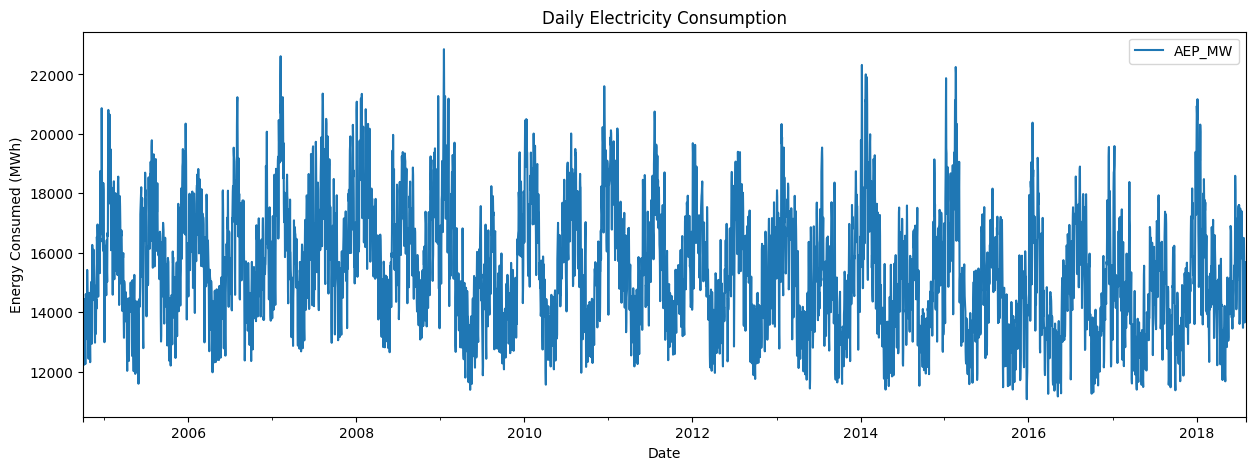

In [5]:
# Student Name: Yamini Saraswathi Borra
# Student ID: 700748022
# Question1: DataSet Preparation
# Select a time series dataset suitable for forecasting tasks (e.g., stock prices,
# weather data, energy consumption).
import pandas as pd
!pip install matplotlib
import matplotlib.pyplot as plt

# Replace the path with your actual file path where the CSV file is stored
file_path = 'C:/Users/M1097753/Downloads/archive/AEP_hourly.csv'

# Load the dataset
df = pd.read_csv(file_path)

# Convert the Datetime column to a datetime type and set it as the index
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# For simplicity, let's resample the data to daily frequency by taking the average daily consumption
df_daily = df.resample('D').mean()

# Quick visualization to understand the data
df_daily.plot(figsize=(15, 5))
plt.title('Daily Electricity Consumption')
plt.ylabel('Energy Consumed (MWh)')
plt.xlabel('Date')
plt.show()


In [9]:
#Student Name: Yamini Saraswathi Borra
#Student ID: 700748022
#Question1: DataSet Preparation
#Preprocess the dataset, including normalization and splitting into training
#and test sets.
import numpy as np

# Check for missing values
if df_daily.isnull().sum().sum() > 0:
    # Fill missing values with the previous day's data
    df_daily.fillna(method='ffill', inplace=True)


In [10]:
# Normalize the Dataset
!pip install scikit-learn

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df_daily_scaled = scaler.fit_transform(df_daily.values.reshape(-1, 1))  # Reshape is required to make it 2D array
df_daily_scaled = np.squeeze(df_daily_scaled)  # Convert back to 1D array for simplicity


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\M1097753\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [11]:
#Split the Data into Training and Test Sets
# Define the train and test set sizes
train_size = int(len(df_daily_scaled) - 365)
test_size = len(df_daily_scaled) - train_size

# Split the data into train and test sets
train, test = df_daily_scaled[0:train_size], df_daily_scaled[train_size:len(df_daily_scaled)]

print(f'Train set size: {len(train)}')
print(f'Test set size: {len(test)}')


Train set size: 4690
Test set size: 365


In [13]:
#Example of a Time Series Forecasting Model Setup
%pip install statsmodels

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit the ARIMA model on the training data
model = ARIMA(train, order=(1, 1, 1))  # These parameters (p,d,q) usually require tuning
fitted_model = model.fit()

# Forecasting the next 'test_size' points to compare against the actual test set
forecast = fitted_model.forecast(steps=test_size)

# Inverse the scaling to compare it against the original data
forecast = scaler.inverse_transform(forecast.reshape(-1, 1))
test_original = scaler.inverse_transform(test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(train), len(train) + len(test)), test_original, label='Actual Test Data')
plt.plot(np.arange(len(train), len(train) + len(test)), forecast, color='red', label='Forecasted Data')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\M1097753\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


NameError: name 'train' is not defined

In [2]:
#2. Model Architecture - Design an LSTM-based architecture capable of capturing long-term dependencies in the input sequences.
#Step1: Prepare the data for LSTM
import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Function to create sequences of data
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

# Number of past days we want to use to predict the future
look_back = 14  # Use the last 14 days to predict the next day

# Prepare data
train_X, train_Y = create_dataset(train.reshape(-1,1), look_back)
test_X, test_Y = create_dataset(test.reshape(-1,1), look_back)

# Reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))


NameError: name 'train' is not defined

In [ ]:
#Step 2: Design the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
#Step 3: Train the Model
# Fit the model
history = model.fit(train_X, train_Y, epochs=20, batch_size=32, validation_split=0.1, verbose=1)


In [ ]:
#Step4: Evaluate the Model
# Predicting and reversing normalization
test_predict = model.predict(test_X)
test_predict = scaler.inverse_transform(test_predict)
test_Y_actual = scaler.inverse_transform(test_Y.reshape(-1, 1))

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(test_Y_actual, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.title('Energy Consumption: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()


In [8]:
#2. Model Architecture - Experiment with stacking multiple LSTM layers and adjusting the number of units in each layer.
# Step 1 : Prepare the Data

import numpy as np

def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)
# Assuming you have loaded and preprocessed your data here
# Define train and test datasets
train_data = 13478.0,12865.0
test_data = 12577.0,12517.0

# Assuming you have normalized your data and created train_X, train_Y, test_X, test_Y as shown in the previous examples

look_back = 14  # Using the last 14 days to predict the next day

# Assuming 'train' and 'test' are your datasets split from normalized data
train_X, train_Y = create_dataset(train.reshape(-1,1), look_back)
test_X, test_Y = create_dataset(test.reshape(-1,1), look_back)

train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))


NameError: name 'train' is not defined

In [3]:
# Step 2: Design a Stacked LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Building the model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(look_back, 1)),  # First layer with more units
    LSTM(50, return_sequences=True),  # Second layer
    LSTM(25),  # Third layer with fewer units
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\M1097753\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
#Step 3: Train the Model
history = model.fit(train_X, train_Y, epochs=50, batch_size=32, validation_split=0.1, verbose=1)


NameError: name 'train_X' is not defined

In [6]:
# Step 4: Evaluate the Model
# Making predictions
test_predict = model.predict(test_X)

# Assuming 'scaler' was used for normalizing the dataset
test_predict = scaler.inverse_transform(test_predict)
test_Y_actual = scaler.inverse_transform(test_Y.reshape(-1, 1))

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(test_Y_actual, label='Actual Energy Consumption')
plt.plot(test_predict, label='Predicted Energy Consumption')
plt.title('Energy Consumption Forecast')
plt.xlabel('Time Step')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()


NameError: name 'test_X' is not defined

In [ ]:
# 2. Model Architecture - Consider using dropout layers to prevent overfitting and improve generalization.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model with dropout layers
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),  # Dropout layer with a dropout rate of 0.2
    LSTM(50, return_sequences=True),
    Dropout(0.2),  # Dropout layer with a dropout rate of 0.2
    LSTM(25),
    Dropout(0.2),  # Dropout layer with a dropout rate of 0.2
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# Student Name: Yamini Saraswathi Borra
# Student ID: 700748022
# 3. Model Training - Compile the LSTM model with an appropriate loss function (e.g., mean squared error) and optimizer (e.g., Adam).
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(look_back, 1)),
    LSTM(50, return_sequences=True),
    LSTM(25),
    Dense(1)
])

# Compile the model with mean squared error loss function and Adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error')



In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
model.compile(optimizer=optimizer, loss='mean_squared_error')


In [4]:
# 3. Model Training - Train the model on the training set for a fixed number of epochs.
# Assuming you have defined and compiled your LSTM model as 'model'
# Also assuming you have prepared your training data 'train_X' and 'train_Y'

# Define the number of epochs
num_epochs = 50  # Adjust as needed

# Train the model on the training set for a fixed number of epochs
history = model.fit(train_X, train_Y, epochs=num_epochs, batch_size=32, verbose=1)


NameError: name 'train_X' is not defined